# Topic Modeling

Akio Kakishima

### Sources

https://radimrehurek.com/gensim/models/ldaseqmodel.html

https://markroxor.github.io/gensim/static/notebooks/ldaseqmodel.html

https://www.youtube.com/watch?v=7BMsuyBPx90 <-- Dave Blei's Google talk on Dynamic Topic Modelling

https://towardsdatascience.com/exploring-the-un-general-debates-with-dynamic-topic-models-72dc0e307696 

^ Explains why each new paragraph should be treated as a separate document in DTM


### Notes
This .ipynb file runs topic modeling. Make sure to have parsed the PDFs before running this analysis. 

In [177]:
BIGRAMS = False
LOAD_DICTIONARY = True
LOAD_LDA = True
LOAD_DTM = True
threshold = 25

if LOAD_DTM or LOAD_LDA:
    num_topics = 10
else: 
    num_topics = [10,15,20]

In [166]:
from collections import Counter
from gensim import models
from gensim.corpora import Dictionary, bleicorpus
from gensim.models import ldaseqmodel, ldamodel
from gensim.models.wrappers.dtmmodel import DtmModel
from gensim.test.utils import datapath
import pyLDAvis
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer 
import numpy as np
import os
import pandas as pd # ver 0.24.2
import pickle
import re
import time
import winsound

In [167]:
def remove_threshold(input_list, thresh):
    output_set = set()
    c = Counter(input_list)
    for each in c:
        if c[each] <= thresh:
            output_set.add(each)
    return output_set

In [168]:
def preprocess(raw, BIGRAM):
    """
    Takes in a string, lowercases all the text,
    fixes hyphenation, then tokenizes the input. 
    Outputs a list of all the tokens in the input document. 
    Each token is at least 3 chars long. 
    Also removed numbers, and stopwords. 
    Stopwords downloaded from nltk.downloads('stopwords'). 

    Parameters
    ----------
    first : string, or parser 
        `raw` is the pdf document

    Returns
    -------
    list
        A list of each token, stopword filtered

    """

    lowered = raw.lower()
    fixed = re.sub(r'[\-]\W+', '', lowered)
    whitespace = re.sub(r'[\W]+', ' ', fixed)

    tokenizer = RegexpTokenizer(r'[A-z]{4,}')
    additional_list = ['also', 'ndr', 'red', 'crescent', 'cross', 'world', 'disaster', 'report', 'chap', 'page', 'ifrc','unhcr']
    tokenized = [word for word in tokenizer.tokenize(fixed) if word not in additional_list]
    
    
    lemmatizer = WordNetLemmatizer()
    lemmed = [lemmatizer.lemmatize(word) for word in tokenized if word not in stopwords.words('english')]

    remove_set = remove_threshold(lemmed, threshold)
    
    lemmed_filtered = [i for i in lemmed if i not in remove_set]
    
    if BIGRAM:
        bigram = list(nltk.bigrams(lemmed_filtered))
        filtered_words = [i for i in map('_'.join, bigram)]
    else:
        filtered_words = lemmed_filtered
    
    return filtered_words

In [169]:
def extract_para(raw, len_list):
    """
    Input is lowercased, and split by paragraph breaks
    using regex. The number of paragraphs are analyzed
    and appended in input list, 'len_list'
    
    Returns a list, 'list_of_paragraphs', which is the
    output from the split function.

    Parameters
    ----------
    first : string
        text of the PDF file
    second : list
        list to keep track of number of paragraph 
        extracted from input, 'raw'
        
    Returns
    -------
    list

    """

    lowered = raw.lower()
    list_of_paragraphs = re.split(r'\.[ ][\n]+', lowered)
    len_list.append(len(list_of_paragraphs))
    
    return list_of_paragraphs

In [170]:
def determine_year(pdf_title):
    searchObj = re.search(r'20[0-9]{2}|19[0-9]{2}', pdf_title, re.M|re.I)
    if searchObj:
        year = searchObj.group()
    
    return int(year)

In [171]:
def beeper():
    '''
    Beeps when activated
    '''
    
    eighth = 250
    half = 1000
    g = 392 #hz
    ef = 311 #hz

    for i in range(3):
        winsound.Beep(g, eighth)
    winsound.Beep(ef, half)

## Get/Set common_corpus and common_dictionary

In [172]:
%%time

if LOAD_DICTIONARY:
    print("loading Dictionary, corpus, and len documents")
    common_dictionary = Dictionary.load('model/common_dictionary')
    with open('model/common_corpus_pickled', 'rb') as f:
        common_corpus = pickle.load(f)
    with open('model/len_docs_pickled', 'rb') as f:
        lengths_of_docs = pickle.load(f)
    with open('model/common_corpus_test_pickled', 'rb') as f:
        common_corpus_test = pickle.load(f)
    with open('model/len_docs_test_pickled', 'rb') as f:
        lengths_of_docs_test = pickle.load(f)    
else:
    print("Dictionary, corpus, and len documents not found; initializing")

    print('trainset')
    text_library = {}
    list_of_string = []
    list_of_list_of_string = []
    lengths_of_docs = []

    path = "data/"
    dirs = os.listdir(path)
    for each_pdf in dirs:
        if each_pdf == 'WDR-2018-EN-LR.pdf': pass # our testset
        else:
            print(each_pdf)       
            with open('txt/{}.txt'.format(str(each_pdf)), 'r', encoding='utf8') as f:
                text = f.read()
                text_year = determine_year(each_pdf)
                try:
                    text_update = "{}\n{}".format(text_library[text_year], text)
                    text_library.update({text_year: text_update})
                except:
                    text_library[text_year] = text

    for i in sorted(text_library):
        print("year: {}".format(i))
        text = text_library[i]
        list_of_paragraphs = extract_para(text, lengths_of_docs)
        for i in list_of_paragraphs:
            if len(i) > 3:
                list_of_list_of_string.append(preprocess(i, BIGRAMS))
            else: pass

    # Create a corpus from a list of texts
    common_dictionary = Dictionary(list_of_list_of_string)
    common_corpus = [common_dictionary.doc2bow(text) for text in list_of_list_of_string]
    
    with open('model/common_corpus_pickled', 'wb') as f:
        pickle.dump(common_corpus, f)
    with open('model/len_docs_pickled', 'wb') as f:
        pickle.dump(lengths_of_docs, f)
    
    print('testset')
    text_library_test = {}
    list_of_string_test = []
    list_of_list_of_string_test = []
    lengths_of_docs_test = []

    for each_pdf in dirs:
        if each_pdf == 'WDR-2018-EN-LR.pdf': # our testset
            print(each_pdf)       
            with open('txt/{}.txt'.format(str(each_pdf)), 'r', encoding='utf8') as f:
                text = f.read()
                text_year = determine_year(each_pdf)
                text_library_test[text_year] = text
        else: pass

    for i in sorted(text_library_test):
        print("year: {}".format(i))
        text = text_library_test[i]
        list_of_paragraphs_test = extract_para(text, lengths_of_docs_test)
        for i in list_of_paragraphs_test:
            if len(i) > 3:
                list_of_list_of_string_test.append(preprocess(i, BIGRAMS))
            else: pass

    # Create a corpus from a list of texts
    common_dictionary.add_documents(list_of_list_of_string_test)
    common_corpus_test = [common_dictionary.doc2bow(text) for text in list_of_list_of_string_test]

    common_dictionary.save('model/common_dictionary')
    
    with open('model/common_corpus_test_pickled', 'wb') as f:
        pickle.dump(common_corpus_test, f)
    with open('model/len_docs_test_pickled', 'wb') as f:
        pickle.dump(lengths_of_docs_test, f)

loading Dictionary, corpus, and len documents
Wall time: 3.49 ms


## NMF

In [173]:
# nmf = models.Nmf(common_corpus, num_topics=10)

## Baseline: LDA

In [178]:
%%time
home = os.getcwd()

if LOAD_LDA:
    print("loading LDAmodel")
    lda = ldamodel.LdaModel.load(os.path.join(home, 'model/LDAmodel_{}'.format(num_topics)))
else:
    for num_topics_sub in num_topics:
        print("LDAmodel not found; initializing ldamodel")
        lda = ldamodel.LdaModel(corpus=common_corpus, id2word=common_dictionary, num_topics=num_topics_sub, update_every=1, passes=1)

        print("saving")
        lda.save(os.path.join(home, 'model/LDAmodel_{}'.format(num_topics_sub)))

loading LDAmodel
Wall time: 3.99 ms


In [179]:
def pretty_print_topic(n_w = len(common_dictionary.values())):
    epoch = []
    topic_list = []
    topic_imp = []
    
    for idx, each_topic in enumerate(lda.print_topics(num_topics=num_topics, num_words=n_w)):
        # len(common_dictionary.values()) = gets all vocab
        for each_token in each_topic[1].split('+'):
            topic_importance, token = each_token.split("*")
            topic_list.append(re.sub(r'[^A-z0-9]+', '', token))
            topic_imp.append(topic_importance)
            epoch.append(idx)
    data = {'epoch': epoch, 'topic': topic_list, 'topic_importance': topic_imp}
    lda_df = pd.DataFrame.from_dict(data)
#     print(len(lda_df))
#     display(lda_df)
    
    return lda_df

lda_df = pretty_print_topic(n_w = 5)

In [180]:
counter = 1
for each_epoch in lda_df['epoch'].unique():
    print("Topic {}\n{}\n".format(counter, lda_df[lda_df['epoch'] == each_epoch]['topic']))
    counter +=1

Topic 1
0     humanitarian
1           person
2           people
3       technology
4    international
Name: topic, dtype: object

Topic 2
5           asylum
6       technology
7             data
8    international
9         disaster
Name: topic, dtype: object

Topic 3
10      people
11       total
12      number
13    reported
14    disaster
Name: topic, dtype: object

Topic 4
15           people
16         disaster
17     humanitarian
18    international
19          society
Name: topic, dtype: object

Topic 5
20             mail
21          society
22    international
23     humanitarian
24         disaster
Name: topic, dtype: object

Topic 6
25    refugee
26    country
27     person
28    climate
29     return
Name: topic, dtype: object

Topic 7
30       person
31       figure
32       people
33          aid
34    community
Name: topic, dtype: object

Topic 8
35      people
36         aid
37     country
38      united
39    disaster
Name: topic, dtype: object

Topic 9
40          mi

## DTM

In [181]:
%%time
home = os.getcwd()

if LOAD_DTM:
    print("loading DTMmodel")
    ldaseq = ldaseqmodel.LdaSeqModel.load('model/DTMmodel_{}'.format(num_topics))
else:
    for num_topics_sub in num_topics:
        print(num_topics)
        print("DTMmodel not found; initializing DTMmodel")
        bc = bleicorpus.BleiCorpus.serialize(fname=os.path.join(home, 'model/blei_{}'.format(num_topics_sub)), corpus=common_corpus)
        ldaseq = ldaseqmodel.LdaSeqModel(corpus=common_corpus, id2word=common_dictionary, time_slice=lengths_of_docs, num_topics=num_topics_sub)
        # ldaseq.print_topics(time=0)

        print("saving")
        ldaseq.save(os.path.join(home, 'model/DTMmodel_{}'.format(num_topics_sub)))

loading DTMmodel
Wall time: 30.9 ms


In [182]:
def output_dtm(as_csv = False):
    '''
    Saves output of DTM as csv
    '''
    if as_csv:
        with open('dtm_output.csv', 'w', newline='') as f:
            csv_writer = csv.writer(f)
            csv_writer.writerow(['topic', 'time', 'term', 'topic_importance'])
            for t in range(len(lengths_of_docs)):
                counter = 0
                for i in ldaseq.print_topics(time=t, top_terms=15):
            #         print(i)
                    counter += 1
                    for j in range(len(i)):
                        csv_writer.writerow([counter,t,i[j][0], i[j][1]])
    else:
        pandas_dict = {}
        counter = 0
        for each_epoch in range(len(lengths_of_docs)):
            for each_topic, i in enumerate(ldaseq.print_topics(time=each_epoch, top_terms=len(common_dictionary.values()))):
                for each_tuple in i:
                    (term, importance) = each_tuple
                    pandas_dict.update({counter: [each_epoch, each_topic, term, importance]})
                    counter += 1
        output_df = pd.DataFrame.from_dict(pandas_dict, orient='index', columns=['epoch', 'topic_number', 'topic_terms', 'topic_importance'])
        return output_df

In [183]:
dtm_df = output_dtm()
dtm_df.head()

,epoch,topic_number,topic_terms,topic_importance
0,0,0,people,0.028344
1,0,0,discrimination,0.028075
2,0,0,woman,0.022676
3,0,0,older,0.016411
4,0,0,community,0.016341


In [100]:
def display_viz(save = True, time = 0):
    doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=time, corpus = common_corpus)
    vis_wrapper = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
    if save:
        pyLDAvis.save_html(vis_wrapper, 'viz/DTM{}_viz.html'.format(num_topics))
    else: pass
    return pyLDAvis.display(vis_wrapper)

In [184]:
display_viz(save= False, time=0)

C:\Users\Akio\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


lambda = 1 results in the familiar ranking of terms in decreasing order of their topic-specific probability, and setting lambda = 0 ranks terms solely by their lift

lift: the ratio of a term’s probability within a topic to its marginal probability across the corpus.

# Plots

In [162]:
def plot_specific_topic(tn, term = 'geneva'):
    val_list = []
    for i in ldaseq.print_topic_times(topic=tn, top_terms=len(common_dictionary.values())):
        for each_tup in i:
            if each_tup[0] == term:
                val_list.append(each_tup[1])
            else: pass
    plt.figure(figsize=(9, 7))
    plt.title('Topic Importance over Years')
    plt.plot(val_list)
    plt.xticks(np.arange(18), range(2000,2018))
    plt.xlabel('years')
    plt.ylabel('Topic Importance')
    plt.show()

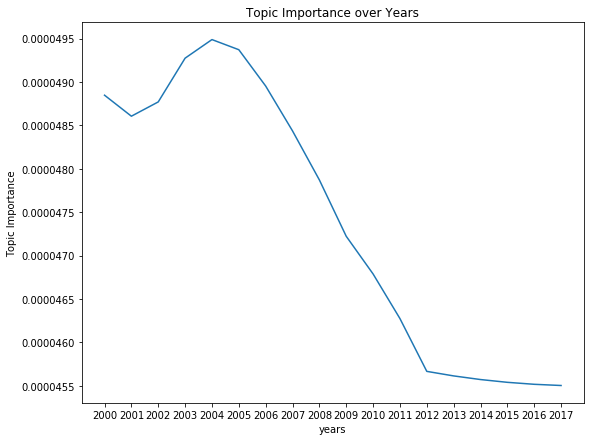

In [186]:
plot_specific_topic(tn = 9, term = 'locust')

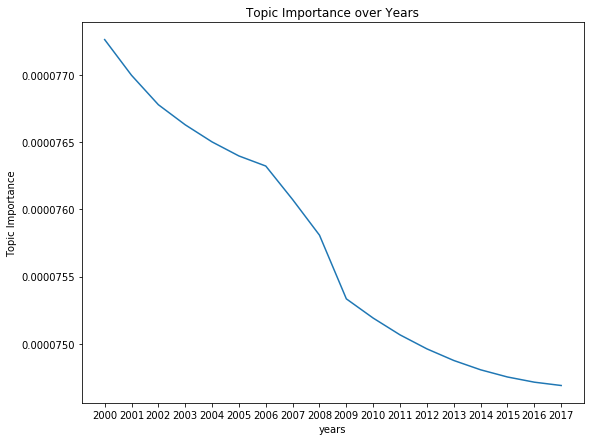

In [187]:
plot_specific_topic(tn = 0, term = 'locust')

# Predict distributions

In [24]:
[print(i) for i in common_dictionary.items()]

(0, 'data')
(1, 'disaster')
(2, 'total')
(3, 'http')
(4, 'international')
(5, 'mail')
(6, 'redcross')
(7, 'society')
(8, 'people')
(9, 'recovery')
(10, 'relief')
(11, 'community')
(12, 'volunteer')
(13, 'affected')
(14, 'annual')
(15, 'average')
(16, 'cent')
(17, 'development')
(18, 'human')
(19, 'killed')
(20, 'natural')
(21, 'number')
(22, 'reported')
(23, 'based')
(24, 'challenge')
(25, 'chapter')
(26, 'cost')
(27, 'flood')
(28, 'government')
(29, 'hazard')
(30, 'local')
(31, 'many')
(32, 'mitigation')
(33, 'preparedness')
(34, 'programme')
(35, 'project')
(36, 'reduction')
(37, 'risk')
(38, 'vulnerability')
(39, 'year')
(40, 'rise')
(41, 'change')
(42, 'climate')
(43, 'country')
(44, 'island')
(45, 'pacific')
(46, 'earthquake')
(47, 'accountability')
(48, 'actor')
(49, 'agency')
(50, 'assessment')
(51, 'assistance')
(52, 'capacity')
(53, 'committee')
(54, 'conflict')
(55, 'could')
(56, 'cred')
(57, 'crisis')
(58, 'decade')
(59, 'emergency')
(60, 'even')
(61, 'example')
(62, 'figure

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [25]:
def testset():
    lda = ldamodel.LdaModel(corpus=common_corpus_test, \
                            id2word=common_dictionary, \
                            num_topics=num_topics, \
                            update_every=1, \
                            passes=1)
    epoch = []
    topic_list = []
    topic_imp = []

    for idx, each_topic in enumerate(lda.print_topics(num_topics=num_topics, num_words=len(common_dictionary.values()))):
        for each_token in each_topic[1].split('+'):
            topic_importance, token = each_token.split("*")
            topic_list.append(re.sub(r'[^A-z0-9]+', '', token))
            topic_imp.append(topic_importance)
            epoch.append(idx)
    data = {'topic_number': epoch, 'topic': topic_list, 'topic_importance': topic_imp}
    lda_df = pd.DataFrame.from_dict(data)

    return lda_df

In [26]:
testset_df = testset()
testset_df['id']= testset_df['topic'].map(common_dictionary.token2id)
dtm_df['id']= dtm_df['topic_terms'].map(common_dictionary.token2id)
testset_df['id'] = testset_df['id'].apply(int)
testset_df['topic_importance'] = testset_df['topic_importance'].apply(float)
testset_df['epoch'] = 18
testset_df = testset_df.sort_values(['topic_number', 'id'])

C:\Users\Akio\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Akio\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Akio\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

C:\Users\Akio\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Akio\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
C:\Users\Akio\Anaconda3\lib\site-packages\gensim\models\ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(

In [27]:
testset_df.head()

,topic_number,topic,topic_importance,id,epoch
0,0,data,0.002,0,18
334,0,disaster,0.002,1,18
333,0,total,0.002,2,18
332,0,http,0.002,3,18
331,0,international,0.002,4,18


In [28]:
dtm_df['id'] = dtm_df['id'].apply(int)
dtm_df['topic_importance'] = dtm_df['topic_importance'].apply(float)
dtm_df = dtm_df.sort_values(['topic_number', 'epoch', 'id'])
dtm_df.head()

,epoch,topic_number,topic_terms,topic_importance,id
38,0,0,data,0.00007,0
9,0,0,disaster,0.00007,1
82,0,0,total,0.00007,2
3,0,0,http,0.00007,3
8,0,0,international,0.00007,4


In [29]:
len(dtm_df['epoch'].unique())

18

In [30]:
for each_epoch in range(len(dtm_df['epoch'].unique())):
    print("{}: {}".format(each_epoch, len(dtm_df[dtm_df['epoch'] == each_epoch]['id'].unique())))

0: 484
1: 484
2: 484
3: 484
4: 484
5: 484
6: 484
7: 484
8: 484
9: 484
10: 484
11: 484
12: 484
13: 484
14: 484
15: 484
16: 484
17: 484


In [31]:
testset_id_set = set(testset_df['id'].unique())
dtm_df_id_set = set(dtm_df[dtm_df['epoch']==1]['id'].unique())

missing_in_dtm = testset_id_set.difference(dtm_df_id_set)
print(missing_in_dtm)

{484, 485, 486, 487, 488, 489, 490, 491}


In [32]:
additional_data = {}
row_num = 435599+1
for each_epoch in range(len(dtm_df['epoch'].unique())):
    for each_tn in range(num_topics):
        for i in missing_in_dtm:
            # epoch, topic_number, topic_terms, topic_importance, id
            additional_data.update({row_num: [each_epoch, each_tn, common_dictionary.id2token[i], 0.0000001, i]})
            row_num+=1
additional_data

{435600: [0, 0, 'file', 1e-07, 484],
 435601: [0, 0, 'content', 1e-07, 485],
 435602: [0, 0, 'site', 1e-07, 486],
 435603: [0, 0, 'uploads', 1e-07, 487],
 435604: [0, 0, 'default', 1e-07, 488],
 435605: [0, 0, 'icrc', 1e-07, 489],
 435606: [0, 0, 'reliefweb', 1e-07, 490],
 435607: [0, 0, 'unocha', 1e-07, 491],
 435608: [0, 1, 'file', 1e-07, 484],
 435609: [0, 1, 'content', 1e-07, 485],
 435610: [0, 1, 'site', 1e-07, 486],
 435611: [0, 1, 'uploads', 1e-07, 487],
 435612: [0, 1, 'default', 1e-07, 488],
 435613: [0, 1, 'icrc', 1e-07, 489],
 435614: [0, 1, 'reliefweb', 1e-07, 490],
 435615: [0, 1, 'unocha', 1e-07, 491],
 435616: [0, 2, 'file', 1e-07, 484],
 435617: [0, 2, 'content', 1e-07, 485],
 435618: [0, 2, 'site', 1e-07, 486],
 435619: [0, 2, 'uploads', 1e-07, 487],
 435620: [0, 2, 'default', 1e-07, 488],
 435621: [0, 2, 'icrc', 1e-07, 489],
 435622: [0, 2, 'reliefweb', 1e-07, 490],
 435623: [0, 2, 'unocha', 1e-07, 491],
 435624: [0, 3, 'file', 1e-07, 484],
 435625: [0, 3, 'content', 

In [33]:
new_data = pd.DataFrame.from_dict(additional_data, orient='index', columns=['epoch', 'topic_number', 'topic_terms', 'topic_importance', 'id'])
new_data.head()

,epoch,topic_number,topic_terms,topic_importance,id
435600,0,0,file,1.000000e-07,484
435601,0,0,content,1.000000e-07,485
435602,0,0,site,1.000000e-07,486
435603,0,0,uploads,1.000000e-07,487
435604,0,0,default,1.000000e-07,488


In [34]:
dtm_df = pd.concat([dtm_df, new_data], ignore_index=True)
dtm_df.tail()

,epoch,topic_number,topic_terms,topic_importance,id
442795,17,49,uploads,1.000000e-07,487
442796,17,49,default,1.000000e-07,488
442797,17,49,icrc,1.000000e-07,489
442798,17,49,reliefweb,1.000000e-07,490
442799,17,49,unocha,1.000000e-07,491


In [35]:
for each_epoch in range(len(dtm_df['epoch'].unique())):
    print("{}: {}".format(each_epoch, len(dtm_df[dtm_df['epoch'] == each_epoch]['id'].unique())))

0: 492
1: 492
2: 492
3: 492
4: 492
5: 492
6: 492
7: 492
8: 492
9: 492
10: 492
11: 492
12: 492
13: 492
14: 492
15: 492
16: 492
17: 492


In [36]:
new_dict = {}
counter = 0
for each_epoch in dtm_df['epoch'].unique():
    new_dict.update({counter: list(dtm_df[dtm_df['epoch'] == each_epoch]['topic_importance'])})
    counter+=1

In [37]:
len(new_dict)

18

In [38]:
new_dict_testset_df = {}
counter = 0
for each_epoch in testset_df['epoch'].unique():
    new_dict_testset_df.update({counter: list(testset_df[testset_df['epoch'] == each_epoch]['topic_importance'])})
    counter+=1
len(new_dict_testset_df)

1

In [39]:
train_df = pd.DataFrame.from_dict(new_dict, orient='index')
train_df.head()
testset_df = pd.DataFrame.from_dict(new_dict_testset_df, orient='index')
testset_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24590,24591,24592,24593,24594,24595,24596,24597,24598,24599
0,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,0.002,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sklearn

In [40]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import GridSearchCV

In [43]:
from sklearn.neural_network import MLPRegressor

y_test = testset_df.to_numpy().flatten()
X_test = train_df.tail(17).to_numpy().T
y_train = (train_df.tail(1).to_numpy()).flatten()
X_train = (train_df.head(17).to_numpy()).T

print("y_test: {}\ny_train: {}\nX_test: {}\nX_train: {}".format(y_test.shape, y_train.shape, X_test.shape, X_train.shape))

# Scaling
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)


param_grid = [
  {'hidden_layer_sizes': [(100000,)], 'alpha': [0.00001]}]

mlp = MLPRegressor()
clf = GridSearchCV(mlp, param_grid=param_grid, cv=5, n_jobs=-1)
clf.fit(X_train, y_train)

print(clf.best_estimator_)
print(mean_squared_error(y_test, clf.predict(X_test)))

y_test: (24600,)
y_train: (24600,)
X_test: (24600, 17)
X_train: (24600, 17)


MemoryError: 

In [141]:
y_test = testset_df.to_numpy().flatten()
X_test = train_df.tail(17).to_numpy().T
y_train = (train_df.tail(1).to_numpy()).flatten()
X_train = (train_df.head(17).to_numpy()).T

# Scaling
scaler = StandardScaler() 
scaler.fit(X_train)  
X_train = scaler.transform(X_train)  
X_test = scaler.transform(X_test)

# Dummy Regressor
clf_dumb = DummyRegressor()
clf_dumb.fit(X_train, y_train)

# NN Regressor
clf = KNeighborsRegressor(n_neighbors=20, n_jobs=-1)
clf.fit(X_train, y_train)

# Check error
print("dummy MSE: ", mean_squared_error(y_test, clf_dumb.predict(X_test)))
print("KNN mse: ", mean_squared_error(y_test, clf.predict(X_test)))

StandardScaler(copy=True, with_mean=True, with_std=True)

DummyRegressor(constant=None, quantile=None, strategy='mean')

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=20, p=2,
          weights='uniform')

dummy MSE:  0.00013591573214964906
KNN mse:  0.0005788273348822681


In [143]:
clf.predict(X_test)

array([6.62430774e-05, 6.62504441e-05, 6.62311721e-05, ...,
       1.00000000e-07, 1.00000000e-07, 1.00000000e-07])